In [1]:
import os
import esprima
import pandas as pd

In [2]:
## config
DF_THRESHOLD = 0.02

## change folder path here
DATA_FOLDER_PATH = "../../better_data/"

### 1.1 Read files

Reads all files in the folder and generates a dataframe with 3 columns - "file_name" with filename of document, 
"file_content" with entire contents of the file unparsed, "tokens" with list of string tokens in each document 

In [3]:
files = os.listdir(DATA_FOLDER_PATH)
print("Number of files in the data folder: ", len(files))

Number of files in the data folder:  4561


In [4]:
def read_file(filename, df):
    filepath  = os.path.join(DATA_FOLDER_PATH, filename)
    with open(filepath,'r') as f:
        file_content = f.read()
        tokens = get_file_tokens(file_content)
        new_row = {"file_name": filename, "file_content": file_content, "tokens": tokens}
        df = df.append(new_row, ignore_index = True)
    return df

In [5]:
def get_file_tokens(content):
    lines = content.split("\n")
    literals = []
    for line in lines:
        line_tokens = esprima.tokenize(line)
        for line_token in line_tokens:
            if line_token.type=="String":
                curr_literal = ((line_token.value)[1:-1])
                literals.append(curr_literal)
    return literals

In [6]:
df = pd.DataFrame(columns=["file_name", "file_content", "tokens"])
for file in files:
    df = read_file(file, df)

### 1.2 Build vocabulary and generate document frequency of each word

combines tokens from all the files to create "vocab_df" dataframe with "token" column with unique tokens from all files

In [7]:
df["tokens"][0]

['https://better.com/',
 "See today\\'s rates",
 'See rates',
 'First, are you buying?',
 "I\\'m going to open houses",
 'See how much I can afford',
 'Not Sure',
 '30000',
 'City, state, or zip',
 'CityNameWithZipCode 30000 CA, USA',
 'Next',
 'Primary residence',
 'Single Family',
 'Next',
 'user0@gmail.com',
 'Email',
 'Continue']

In [8]:
df["file_content"][0]

"  await goto('https://better.com/');\n  await click('See today\\'s rates');\n  await click('See rates', near('First, are you buying?'));\n  await click(near('I\\'m going to open houses'));\n  await click(near('See how much I can afford'));\n  await click(near('Not Sure'));\n  await write('30000', into(textBox('City, state, or zip'))) // <--- user entered text\n  await click('CityNameWithZipCode 30000 CA, USA'); // <=== choice presented to user\n  await click('Next');\n  await click(near('Primary residence'));\n  await click(near('Single Family'));\n  await click('Next');\n  await write('user0@gmail.com', into(textBox(near('Email'))))\n  await click('Continue');\n"

In [9]:
vocab_set = set()
for idx, row in df.iterrows():
    tokens= row["tokens"]
    vocab_set.update(tokens)

In [10]:
vocab_df = pd.DataFrame(list(vocab_set), columns=["token"])
vocab_df.head()

,token
0,630
1,215534
2,205193
3,"154 Elm Street, San Carlos, CA"
4,373 Elm


### 1.3 Document frequency

create a new column "df_count" in "vocab_df" with document frequencies of the tokens

In [11]:
num_docs = len(df)
num_docs

4561

In [12]:
def get_df_count(vocab_row):
    count = 0
    for idx, df_row in df.iterrows():
        if vocab_row["token"] in df_row["tokens"]:
            count+=1
    count = count/num_docs
    return count

In [13]:
%%time
# create a vocab df from all unique tokens 
# document frequency(token) = no.of documents with the token/total num of documents
vocab_df["df_count"] = vocab_df.apply(get_df_count, axis = 1)

CPU times: user 12min 31s, sys: 29.9 ms, total: 12min 31s
Wall time: 12min 31s


In [14]:
# #sort the tokens in decreasing order of frequency
# vocab_df.sort_values(by=["df_count"], ascending= False, ignore_index= True)

In [15]:
variable_df =vocab_df[vocab_df["df_count"]<DF_THRESHOLD]

In [16]:
variable_df.head(10)

,token,df_count
0,630,0.000219
1,215534,0.000658
2,205193,0.000219
3,"154 Elm Street, San Carlos, CA",0.000877
4,373 Elm,0.000658
5,102711,0.000877
6,"CityNameWithZipCode 30232 CA, USA",0.001535
7,378 Elm,0.000658
8,1184,0.001096
9,user385@gmail.com,0.000219


In [17]:
#sort the tokens in decreasing order of frequency
variable_df.sort_values(by=["df_count"], ascending= False, ignore_index= True)

,token,df_count
0,Second Home,0.006358
1,user7@gmail.com,0.005262
2,user5@gmail.com,0.005262
3,user8@gmail.com,0.005262
4,user3@gmail.com,0.005262
...,...,...
2744,288750,0.000219
2745,user400@gmail.com,0.000219
2746,"522 Elm Street, San Carlos, CA",0.000219
2747,472 Elm,0.000219


In [18]:
variables = variable_df["token"]
variables= list(variables)

In [19]:
print("Total number of tokens: ", len(vocab_df)) 
print("Length of variables: ", len(variables))

Total number of tokens:  2785
Length of variables:  2749


In [20]:
variables[:10]

['630',
 '215534',
 '205193',
 '154 Elm Street, San Carlos, CA',
 '373 Elm',
 '102711',
 'CityNameWithZipCode 30232 CA, USA',
 '378 Elm',
 '1184',
 'user385@gmail.com']

### 1.4 Visualizations/analysis

In [21]:
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Frequency of token length')

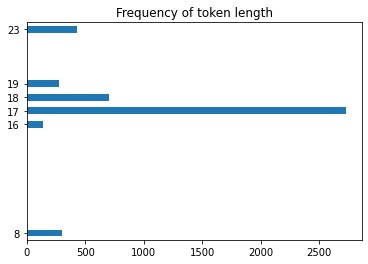

In [22]:
df["token_length"]= df["tokens"].apply(lambda x:len(x))
df["token_length"].value_counts().plot(kind="barh")
plt.title("Frequency of token length")

CPU times: user 2.15 s, sys: 40 ms, total: 2.19 s
Wall time: 2.19 s


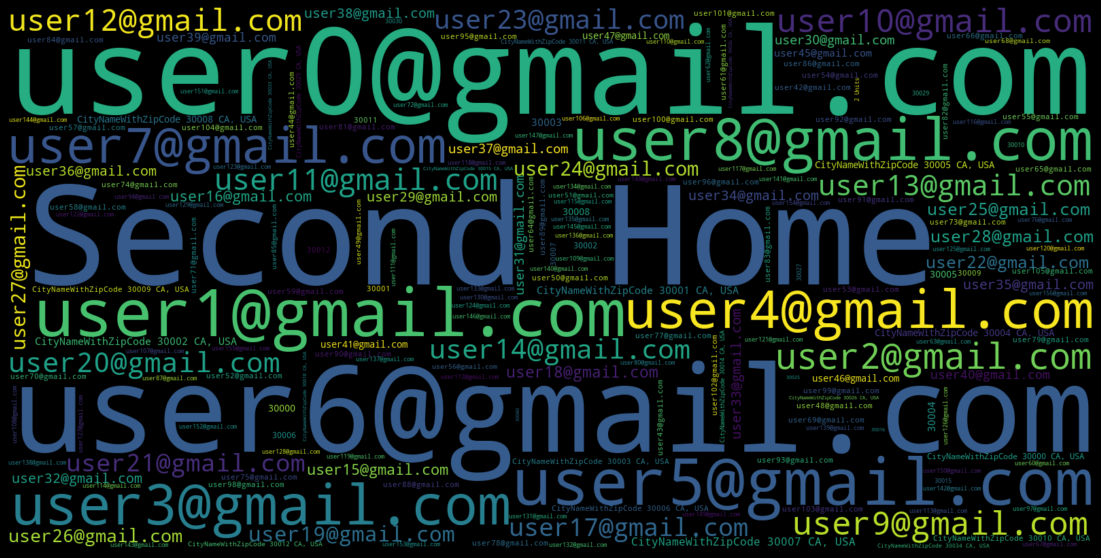

In [23]:
%%time

# create the WordCloud object
wordcloud = WordCloud(width=1600, height = 800)

# background_color='white'
freq_dict = {}
for idx, row in variable_df.iterrows():
    freq_dict[row["token"]] =row["df_count"]
wordcloud.generate_from_frequencies(frequencies=freq_dict)

#plot
plt.figure( figsize=(20,10), facecolor='k' )
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.tight_layout(pad=0)
# plt.show()

plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')

### 2. Replace the variables in the original dataframe 

"replaced_file_content" column is created by replaces variables in "file_content" with "__variable__"

In [24]:
def replace_variables(row, v):
    repl_word = "__variable__"
    for variable in v:
        row = row.replace(variable, "__variable__")
    return row

In [25]:
%%time
# replaced_file_content column is created by modifying 
# replacing the variables with __variable__
df["replaced_file_content"] = df["file_content"].apply(replace_variables, v=variables)

CPU times: user 2.45 s, sys: 0 ns, total: 2.45 s
Wall time: 2.45 s


In [26]:
df["replaced_file_content"][0]

"  await goto('https://better.com/');\n  await click('See today\\'s rates');\n  await click('See rates', near('First, are you buying?'));\n  await click(near('I\\'m going to open houses'));\n  await click(near('See how much I can afford'));\n  await click(near('Not Sure'));\n  await write('__variable__', into(textBox('City, state, or zip'))) // <--- user entered text\n  await click('CityNameWithZipCode __variable__ CA, USA'); // <=== choice presented to user\n  await click('Next');\n  await click(near('Primary residence'));\n  await click(near('Single Family'));\n  await click('Next');\n  await write('__variable__', into(textBox(near('Email'))))\n  await click('Continue');\n"

In [27]:
df["replaced_file_content"][1]

"  await goto('https://better.com/');\n  await click('See today\\'s rates');\n  await click('See rates', near('First, are you buying?'));\n  await click(near('I\\'m going to open houses'));\n  await click(near('Estimate a home\\'s cost'));\n  await click(near('0–3 months'));\n  await write('__variable__', into(textBox('City, state, or zip'))) // <--- user entered text\n  await click('__variable__'); // <=== choice presented to user\n  await click('Next');\n  await click(near('Primary residence'));\n  await click(near('Single Family'));\n  await click('Next');\n  await write('__variable__', into(textBox(near('Email'))))\n  await click('Continue');\n"

Basic Intuition: 

Literals in click method are not variables and first literal in write method is usually a variable.
Threshold can be tuned by basic vizualization of few files at this step. 
If we see too many literals that are being replaced, we can lower the DF_THRESHOLD value at cell2.

In [28]:
# def replace_tokens(row, v):
#     repl_word = "__variable__"
#     row = [repl_word if t in v else t for t in row]
#     return row

In [29]:
# %%time
# # replaced_tokens column is created by replacing the variab with __variable__
# df["replaced_tokens"] = df["tokens"].apply(replace_tokens, v= variables)

In [30]:
# df["replaced_tokens"][0]

In [31]:
print("Total number of documents: ", len(df))
print("Total number of unique documents: ", df["file_content"].nunique())
print("Total number of unique documents after variable replacement: ", df["replaced_file_content"].nunique())

Total number of documents:  4561
Total number of unique documents:  4077
Total number of unique documents after variable replacement:  392
